# Fibrosis-associated macrophage in vitro query and comparisons 
The goal of this demo is to familiarize users with a couple of SCimilarity's more flexible functionalities. The application is to fibrosis-associated macrophages (FM$\phi$) and loosely parallels much of the FM$\phi$ analysisfor Figure 6 from the [SCimilarity manuscript](https://www.biorxiv.org/content/10.1101/2023.07.18.549537v1.abstract).

System requirements:

  - At least 64GB of RAM

## 0. Required software and data
Things you need for this demo:

 0. [SCimilarity](https://github.com/Genentech/scimilarity) package should already be installed.

 1. SCimilarity trained model. [Download SCimilarity models](https://zenodo.org/record/8240464). Note, this is a large tarball - downloading and uncompressing can take a several minutes.

 2. Query data. We will use [Adams et al., 2020](https://www.science.org/doi/10.1126/sciadv.aba1983?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) healthy and IPF lung scRNA-seq data. [Download tutorial data](https://zenodo.org/records/13685881).

For instructions on how to download the demo data or SCimilarity models please check the cell search tutorial.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

sc.set_figure_params(dpi=100)

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
adams = sc.read("/data/GSE136831_subsample.h5ad")

## 1. Identify query population

In [4]:
from scimilarity.utils import lognorm_counts
from scimilarity import CellQuery, align_dataset, Interpreter

### Import SCimilarity - Cell annotation object

In [5]:
# Instantiate the CellQuery object
# Set model_path to the location of the uncompressed model
model_path = "/models/model_v1.1"
cq = CellQuery(model_path)

### SCimilarity pre-processing
**Note, this section is largely repeat of the SCimilarity pre-processing section from the cell search tutorial.**

SCimilarity requires new data to be processed in a specific way that matches how the model was trained. 

#### Match feature space with SCimilarity models 
SCimilarity's gene expression ordering is fixed. New data should be re-orderd to match that. Genes that are not present in the new data will be zero filled to comply to the expected structure. Genes that are not present in SCimilarity's gene ordering will be filtered out. 

Note, SCimilarity was trained with high data dropout to increase robustness to differences in gene lists. 

In [6]:
adams = align_dataset(adams, cq.gene_order)

#### Normalize data consistent with SCimilarity
It is important to match Scimilarity's normalization so that the data matches the lognorm tp10k procedure used during model training.

In [7]:
adams = lognorm_counts(adams)

With these simple steps, the data is now ready for SCimilarity. We are able to filter cells later (even after embedding) because SCimilarity handles each cell indepdendently and can skip highly variable gene selection altogether.

### Identify query cell state
As in the SCimilarity manuscript, we use a signature to identify the cells you want to query. There are many other ways to select a query cell state such as granular clustering and looking at expression patterns of a specific gene.

In [8]:
fm_basic_signature = ["SPP1", "TREM2", "GPNMB", "MMP9", "CHIT1", "CHI3L1"]
sc.tl.score_genes(adams, fm_basic_signature)

### Determine query profile
We will query on the centroid of the top `n` cells that score on our signature.

#### Select the top scoring cells to define our query cell state
To identify similar cells, we input a query profile representing the cell state of interest. In this case, we will use the average expression profile of cells above the 99.9th percentile of our signature score. 

Note, an overly broad cell selection can limit query results.

In [9]:
sig_query_threshold = adams.obs.score.quantile(0.999)
cells_used_in_query = adams.obs.score >= sig_query_threshold
adams.obs["used_in_query"] = cells_used_in_query

#### Compute centroid of top scoring cells and compute embedding

In [10]:
from scimilarity.utils import get_centroid

In [11]:
avg_cell = get_centroid(adams.layers["counts"][adams.obs["used_in_query"]])
avg_embedding = cq.get_embeddings(avg_cell)

### FM$\phi$ Signature derivation
One can use SCimilarity to create a signature using cells from many datasets (e.g., cell search results). Here, for simplicity, we will derive a signature from a single dataset using a cell state predefined with a signature. Typically, users would derive a signature for a new cell state (maybe defined through querying a specific cell cluster) using expression profiles across many datasets.

To derive this signature with SCimilarity, we will compare gene expression profiles (not embeddings directly, although the attribution method uses SCimilirty embeddings) between two populations of cells, the `pos`itive set and the `neg`ative set. Here our positive set will be our high signature scoring cells and our negative set will be all other cells. The results will show the original input signature as well as addition genes associated with the FM$\phi$ cell state. 

#### Select cell sets to compare

In [12]:
pos = adams[adams.obs.score >= sig_query_threshold]
neg = sc.pp.subsample(
    adams[adams.obs.score < sig_query_threshold],
    n_obs=len(pos),
    random_state=0,
    copy=True,
)

#### Use SCimilarity to compare selected cell sets
This computes an attribution score and standard deviation for each gene. The more cells used to compute the signature, the lower the standard deviation.

In [13]:
explainer = Interpreter(cq.model, cq.gene_order)
attrs = explainer.get_attributions(pos.X, neg.X)
attrs_df = explainer.get_ranked_genes(attrs)

#### Visualize genes
While scores are computed for all genes, we will visualize just the top 25. `attrs_df` is already sorted by attribution and we can show the standard deviation atop that to display uncertainty.

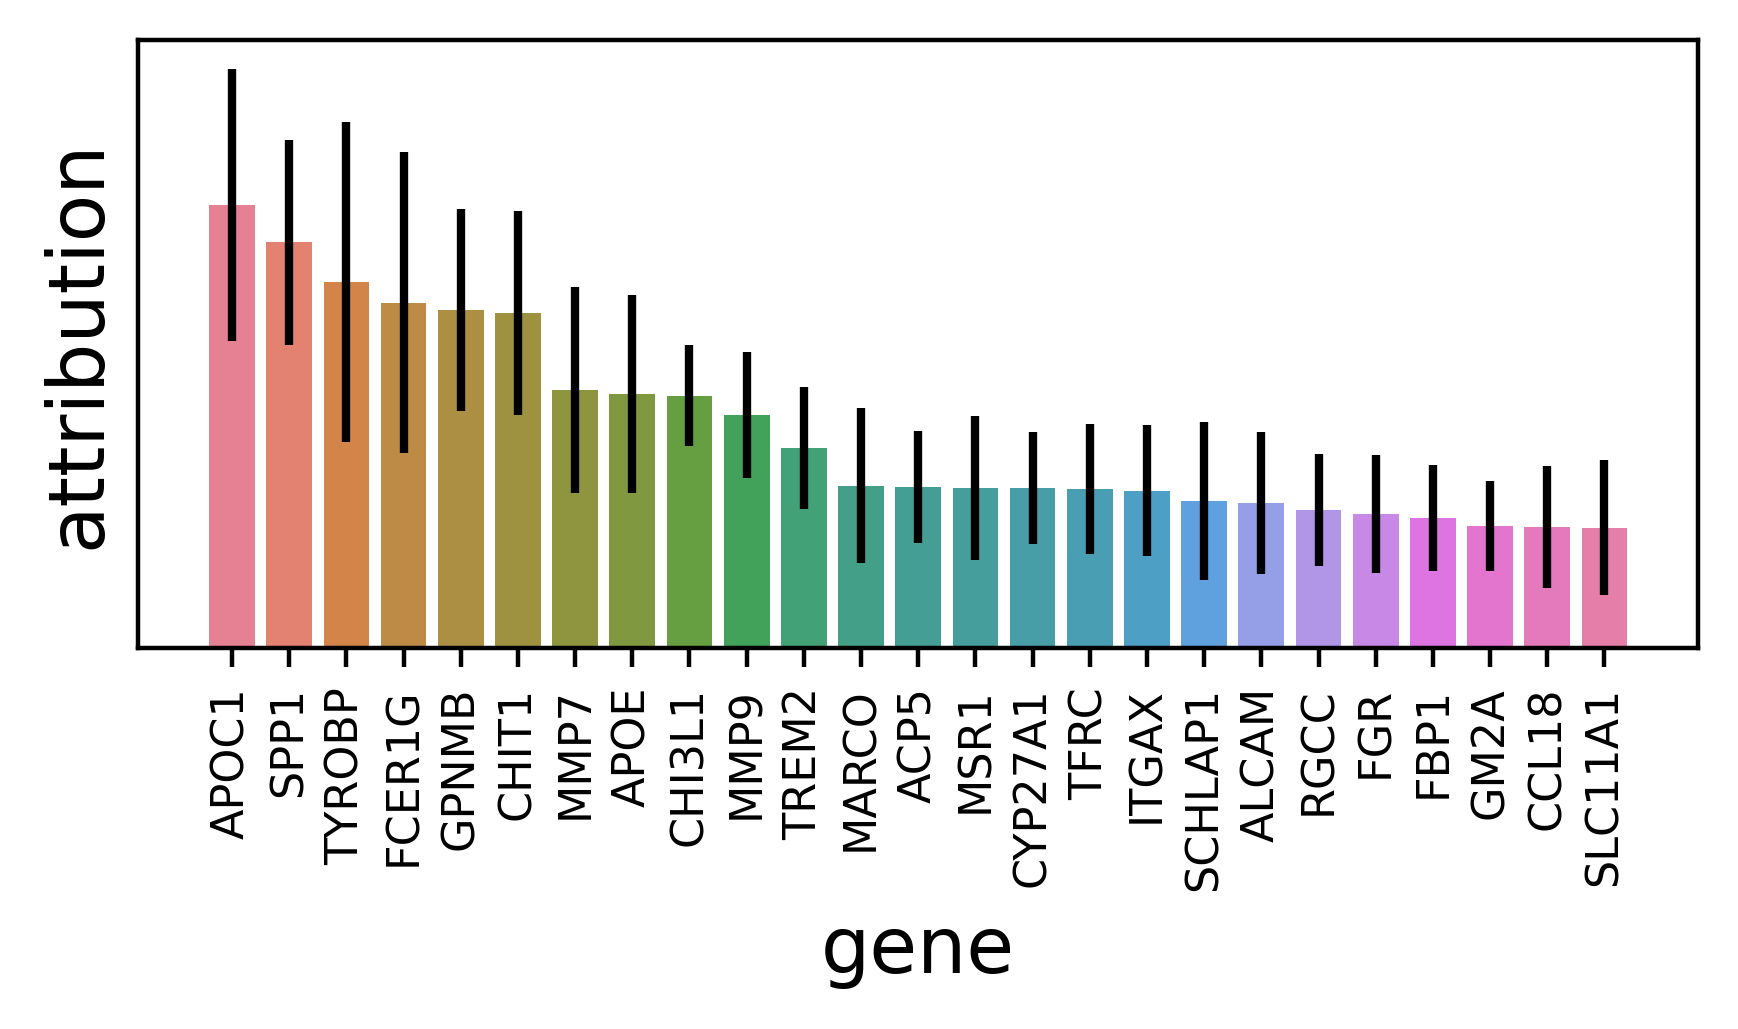

In [14]:
explainer.plot_ranked_genes(attrs_df, n_plot=25)

Note, because we are working off of neural network gradients, we don't have an intuitive understanding of the scale of attribution values. Therefore, we try to avoid quantititavely interpreting them and instead focus on the attribution values relative to other genes within the same comparison. 

## 2. Pairwise distance to all *in vitro* macrophages

### Get all metadata, identify predicted macrophages

In [15]:
meta = cq.cell_metadata

#### SCimilarity models contain all cell and sample metadata - an extremely valuable resource
Each row corresponds to the metadata for one cell. Use it to filter results based on cell type, tissue, disease, *in vitro*, etc.

In [16]:
# Show a random sampling of 5 annotations
meta.sample(5)

,index,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,...,cell_line,iPSC-derived,ESC-derived,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label
22934587,22934587,DS000011735,DS000011735-GSM4058930,alveolar macrophage,-0.239148,1187.0,2471.0,126.0,5.099150,1.514161e-02,...,False,NA,NA,NA,lung,NA,chronic obstructive pulmonary disease,NA,NA,alveolar macrophage
12004876,12004876,ENCODE,ENCFF616DEQ,macrophage,-0.103378,849.0,1141.0,11.0,0.964067,1.489848e-02,...,False,False,False,False,heart left ventricle,NA,NA,NA,NA,NA
20933434,20933434,436154da-bcf1-4130-9c8b-120ff9a888f2,a95f8d98-ff4e-45fc-8ede-1687c1495833,"CD4-positive, alpha-beta T cell",0.000000,559.0,1699.0,40.0,2.354326,-2.384186e-07,...,False,NA,NA,NA,blood,NA,systemic lupus erythematosus,NA,NA,"CD4-positive, alpha-beta T cell"
5533835,5533835,GSE136394,GSM4047948,"CD4-positive, alpha-beta T cell",0.000000,2190.0,5904.0,309.0,5.233740,7.584751e-03,...,False,False,False,False,NA,NA,colorectal cancer,NA,NA,NA
11224869,11224869,GSE139829,GSM4147092,melanocyte,-0.011139,1283.0,2769.0,477.0,17.226435,6.371522e-02,...,False,False,False,False,uvea,NA,melanoma,NA,female,NA


#### Extract precomputed embeddings for all macrophages across samples and studies 
Filter criteria:

 - Must be a macrophage population with >50 macrophages

SCimilarity has built-in Cell Onotology support that the user can import and use in their queries. In this example, we demonstrate the import of monocyte, macrophage and microglia descendants using their ontology and the `get_all_descendant()` method. We then merge the monocyte and macrophage descendants and remove those of the microglia. Using another builtin method `get_id_mapper()` we map the cell identifiers to their names.

In [17]:
from scimilarity.ontologies import (
    import_cell_ontology,
    get_id_mapper,
    get_all_descendants,
)

In [19]:
# prepare cell ontology
onto = import_cell_ontology(url="http://purl.obolibrary.org/obo/cl/cl-basic.obo")
id2name = get_id_mapper(onto)

mono_descendents = get_all_descendants(onto, "CL:0000576", inclusive=True)
mac_descendents = get_all_descendants(onto, "CL:0000235", inclusive=True)
microglia_descendents = get_all_descendants(onto, "CL:0000129", inclusive=True)

momac_ids = pd.Index((mono_descendents | mac_descendents) - microglia_descendents)
momac_cell_types = momac_ids.map(id2name)

From the metadata of SCimilarity datasets we can then select the relevant cell types. 
Since our experimental query cells were cultured *in vitro* we will filter out the cells coming from *in vivo* experiments. 

In [20]:
momac_inds = meta.prediction.isin(momac_cell_types)
in_vitro_inds = (meta["in_vivo"] == "False").values
in_vitro_momac_inds = momac_inds & in_vitro_inds
momac_meta = meta[in_vitro_momac_inds]

#### Extract pre-computed cell embeddings for *in vitro* monocytes and macrophages
After identifying the relevant cells we can compute their embedding in the pretrained model.
This execution is very fast, extracting over 100k cells from across studies in under 2.5s

In [21]:
%%time
momac_embeddings = cq.get_precomputed_embeddings(np.where(in_vitro_momac_inds)[0])
momac_embeddings.shape

CPU times: user 11.6 s, sys: 3.02 s, total: 14.6 s
Wall time: 3.35 s


(145323, 128)

### Compute pairwise distance from query embedding to all other macrophages

We will use the embedding to calculate the distance from query cells to the surrounding cells and calculate their scimilarity as 1/distance.

In [22]:
mac_distances = 1 - (momac_embeddings @ avg_embedding.T).flatten()

momac_meta["distance"] = mac_distances
momac_meta["similarity"] = 1 / mac_distances

momac_meta["sample"] = pd.Categorical(momac_meta["sample"])

We can then narrow the results down to the samples that have a sufficient number of cells (in this example we choose 25 cells).

In [23]:
cell_counts_per_sample = momac_meta.groupby("sample").size()
samples_w_enough_cells = cell_counts_per_sample[cell_counts_per_sample > 25].index
momac_meta = momac_meta[momac_meta["sample"].isin(samples_w_enough_cells)]
momac_meta["sample"] = momac_meta["sample"].cat.remove_unused_categories()

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt

We can plot similarity scores across the relevant studies.

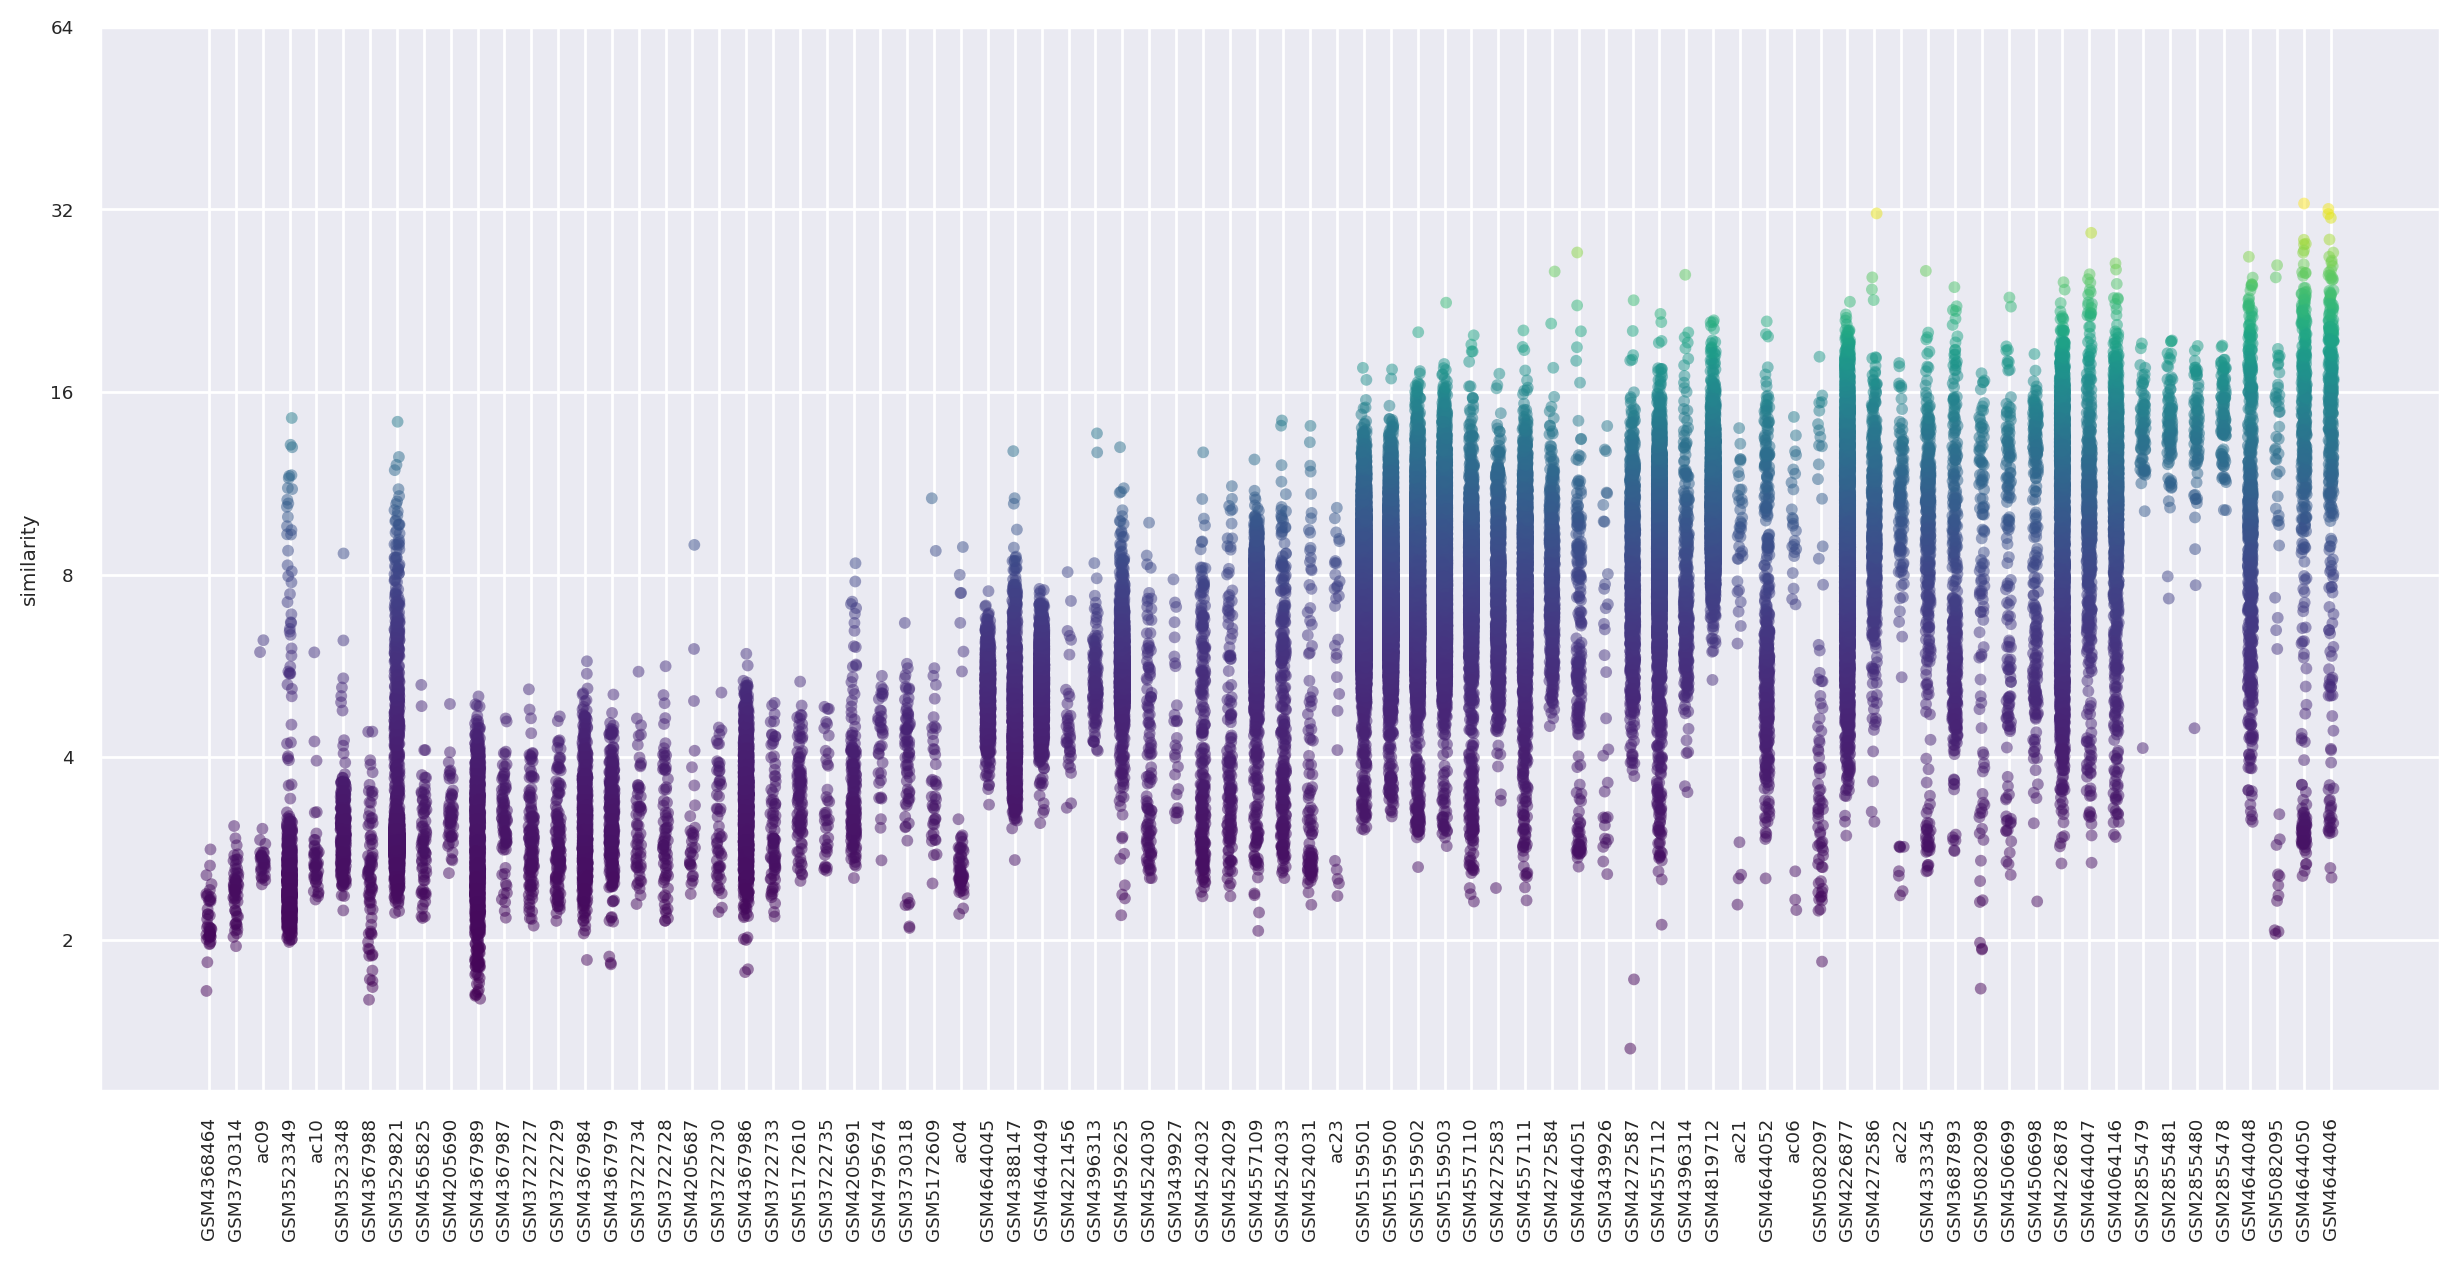

In [25]:
# Disclaimer: this is a somewhat hacky workaround to add jitter to seaborn's scatterplot().
# While stripplot() can do this natively, it's much more resource-hungry.

# 1. Order the categories on the x-axis
sample_order = list(
    momac_meta.groupby("sample")["similarity"].quantile(0.9).sort_values().index
)
momac_meta["sample"] = pd.Categorical(
    momac_meta["sample"], categories=sample_order, ordered=True
)

# 2. Transform the categorical data into numerical values
momac_meta["numeric_sample"] = momac_meta["sample"].cat.codes

# 3. Add jitter (Add more or less jitter depending on the plot by adjust the jitter strength)
jitter_strength = 0.1
momac_meta["jittered_sample"] = momac_meta["numeric_sample"] + np.random.uniform(
    -jitter_strength, jitter_strength, size=len(momac_meta)
)

# 4. Now, plot using the jittered values
sns.set(font_scale=0.6)
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(
    data=momac_meta,
    x="jittered_sample",
    y="similarity",
    hue="similarity",
    palette="viridis",
    linewidth=0,
    size=0.1,
    alpha=0.5,
)

ax.set_yscale("log", base=2)
ax.legend().set_visible(False)
ax.set_yticks([2, 4, 8, 16, 32, 64])
ax.set_yticklabels(["2", "4", "8", "16", "32", "64"])

# Set the x-ticks based on the desired order
ax.set_xticks(range(len(sample_order)))
ax.set_xticklabels(sample_order, rotation=90)
ax.set_xlabel("");

### Interpretation
3 of the four top *in vitro* tissue samples are from the [Xu et al. 2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9237197/) 3D culture system [dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE153421) that we highlight in the SCimilarity manuscript.

 1\. [GSM4644046](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4644046) - samples in 3DCS day05 Donor1\
 2\. [GSM4644050](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4644050) - samples in 3DCS day05 Donor2\
 4\. [GSM4644048](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4644048) - samples in 3DCS day14 Donor1

In [26]:
sample_order[-4:]

['GSM4644048', 'GSM5082095', 'GSM4644050', 'GSM4644046']

At this point, we reccomend downloading the datasets and looking into the experimental design to explore the implications that these new conditions may have on your hypothesis!